In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class GRU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.gru = nn.GRU(config.input_size, config.hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(config.hidden_size//2, config.output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        gru_out, hidden = self.gru(x, hidden)
        last_output = gru_out[:, -1, :]
        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

# trainer 구현

In [11]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")
    
  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [12]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 5000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_size = 19        # 처음 input의 차원의 개수 (feature수와 같다)
  hidden_size=512        # GRU hidden vector size
  output_size = 2        # output 차원의 개수

config = Config()

In [13]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [14]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [15]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


In [16]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 5000
failure(1)의 개수 : 1569


In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [18]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [19]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [20]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3941
Total number of data samples in valid_loader: 1313
Total number of data samples in test_loader: 1314


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
# model, optimizer, loss_function 구현하고 결합시키기
model = GRU(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [24]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/5000_GRU') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [00:00<00:00, 422.91it/s]


Model saved
TRAIN LOSS = 0.0024280527224246696, TRAIN ACC = 0.7102258310073586, 
VALID LOSS = 0.002329047772145326, VALID ACC = 0.7738004569687738, 
epoch 2


100%|██████████| 6/6 [00:00<00:00, 440.64it/s]


Model saved
TRAIN LOSS = 0.0020079326959347187, TRAIN ACC = 0.7683329104288251, 
VALID LOSS = 0.0021038102631521696, VALID ACC = 0.7806549885757806, 
epoch 3


100%|██████████| 6/6 [00:00<00:00, 409.31it/s]


Model saved
TRAIN LOSS = 0.001878319786938578, TRAIN ACC = 0.7853336716569399, 
VALID LOSS = 0.002089831498589846, VALID ACC = 0.7913175932977913, 
epoch 4


100%|██████████| 6/6 [00:00<00:00, 459.57it/s]


Model saved
TRAIN LOSS = 0.0017765602600268984, TRAIN ACC = 0.7970058360822126, 
VALID LOSS = 0.0018668947606620585, VALID ACC = 0.8187357197258187, 
epoch 5


100%|██████████| 6/6 [00:00<00:00, 389.91it/s]


TRAIN LOSS = 0.0016822570155520513, TRAIN ACC = 0.8036031464095408, 
VALID LOSS = 0.0017899070091131346, VALID ACC = 0.8065498857578065, 
epoch 6


100%|██████████| 6/6 [00:00<00:00, 428.65it/s]


Model saved
TRAIN LOSS = 0.001610415980344616, TRAIN ACC = 0.8086780005074854, 
VALID LOSS = 0.0016698833648611912, VALID ACC = 0.8271134805788272, 
epoch 7


100%|██████████| 6/6 [00:00<00:00, 445.51it/s]


TRAIN LOSS = 0.0015577524106413602, TRAIN ACC = 0.8198426795229637, 
VALID LOSS = 0.0016631651088107385, VALID ACC = 0.8248286367098249, 
epoch 8


100%|██████████| 6/6 [00:00<00:00, 427.19it/s]


TRAIN LOSS = 0.0015099908805867495, TRAIN ACC = 0.8195889368180664, 
VALID LOSS = 0.00156425326631347, VALID ACC = 0.8248286367098249, 
epoch 9


100%|██████████| 6/6 [00:00<00:00, 427.60it/s]


TRAIN LOSS = 0.0013963324456189496, TRAIN ACC = 0.8211113930474498, 
VALID LOSS = 0.0016781872497291304, VALID ACC = 0.821020563594821, 
epoch 10


100%|██████████| 6/6 [00:00<00:00, 297.75it/s]


Model saved
TRAIN LOSS = 0.0014979673185133143, TRAIN ACC = 0.8188277087033747, 
VALID LOSS = 0.0017245172637160825, VALID ACC = 0.8301599390708302, 
epoch 11


100%|██████████| 6/6 [00:00<00:00, 392.46it/s]


TRAIN LOSS = 0.0013877309516612964, TRAIN ACC = 0.8246637909160112, 
VALID LOSS = 0.001489552689797081, VALID ACC = 0.8255902513328256, 
epoch 12


100%|██████████| 6/6 [00:00<00:00, 467.31it/s]


Model saved
TRAIN LOSS = 0.0012975562287296507, TRAIN ACC = 0.8304998731286476, 
VALID LOSS = 0.0014601456737663577, VALID ACC = 0.8316831683168316, 
epoch 13


100%|██████████| 6/6 [00:00<00:00, 409.52it/s]


Model saved
TRAIN LOSS = 0.0012640616095813209, TRAIN ACC = 0.8289774168992642, 
VALID LOSS = 0.0013580535852718426, VALID ACC = 0.8339680121858339, 
epoch 14


100%|██████████| 6/6 [00:00<00:00, 409.87it/s]


TRAIN LOSS = 0.00113459524316432, TRAIN ACC = 0.8340522709972088, 
VALID LOSS = 0.0015156234118744152, VALID ACC = 0.8332063975628332, 
epoch 15


100%|██████████| 6/6 [00:00<00:00, 348.55it/s]


Model saved
TRAIN LOSS = 0.0011731364443591935, TRAIN ACC = 0.8332910428825171, 
VALID LOSS = 0.0013102153422536508, VALID ACC = 0.8438690022848438, 
epoch 16


100%|██████████| 6/6 [00:00<00:00, 422.47it/s]


TRAIN LOSS = 0.0011039914795360841, TRAIN ACC = 0.8401420959147424, 
VALID LOSS = 0.0015355977545416454, VALID ACC = 0.8286367098248286, 
epoch 17


100%|██████████| 6/6 [00:00<00:00, 406.15it/s]


TRAIN LOSS = 0.0011122228567807754, TRAIN ACC = 0.838619639685359, 
VALID LOSS = 0.0012194629466361158, VALID ACC = 0.8423457730388424, 
epoch 18


100%|██████████| 6/6 [00:00<00:00, 414.10it/s]


TRAIN LOSS = 0.0010709541418987372, TRAIN ACC = 0.8424257802588175, 
VALID LOSS = 0.0012596164009358623, VALID ACC = 0.8400609291698401, 
epoch 19


100%|██████████| 6/6 [00:00<00:00, 433.80it/s]


Model saved
TRAIN LOSS = 0.001053477945862552, TRAIN ACC = 0.848261862471454, 
VALID LOSS = 0.0011614118472184284, VALID ACC = 0.8484386900228484, 
epoch 20


100%|██████████| 6/6 [00:00<00:00, 453.71it/s]


TRAIN LOSS = 0.0009642017958461255, TRAIN ACC = 0.8487693478812484, 
VALID LOSS = 0.0011164302578066836, VALID ACC = 0.8453922315308454, 
epoch 21


100%|██████████| 6/6 [00:00<00:00, 414.64it/s]


TRAIN LOSS = 0.0009574564171454472, TRAIN ACC = 0.8540979446840903, 
VALID LOSS = 0.0011732528342241924, VALID ACC = 0.8392993145468393, 
epoch 22


100%|██████████| 6/6 [00:00<00:00, 327.77it/s]


TRAIN LOSS = 0.0009053065083529615, TRAIN ACC = 0.8571428571428571, 
VALID LOSS = 0.0011563499919894262, VALID ACC = 0.8469154607768469, 
epoch 23


100%|██████████| 6/6 [00:00<00:00, 431.15it/s]


TRAIN LOSS = 0.0009164885461587526, TRAIN ACC = 0.8609489977163156, 
VALID LOSS = 0.001227675937825455, VALID ACC = 0.8408225437928408, 
epoch 24


100%|██████████| 6/6 [00:00<00:00, 435.52it/s]


TRAIN LOSS = 0.0009173316735962386, TRAIN ACC = 0.8614564831261101, 
VALID LOSS = 0.001454243179685908, VALID ACC = 0.8385376999238385, 
epoch 25


100%|██████████| 6/6 [00:00<00:00, 410.66it/s]


Model saved
TRAIN LOSS = 0.0009128930559015552, TRAIN ACC = 0.8586653133722405, 
VALID LOSS = 0.0010891850450432945, VALID ACC = 0.8583396801218584, 
epoch 26


100%|██████████| 6/6 [00:00<00:00, 401.97it/s]


TRAIN LOSS = 0.0008368097232459493, TRAIN ACC = 0.8708449632073078, 
VALID LOSS = 0.0011598058130027498, VALID ACC = 0.8545316070068545, 
epoch 27


100%|██████████| 6/6 [00:00<00:00, 409.46it/s]


TRAIN LOSS = 0.0008115852069685345, TRAIN ACC = 0.8726211621415885, 
VALID LOSS = 0.0011063889406695223, VALID ACC = 0.856054836252856, 
epoch 28


100%|██████████| 6/6 [00:00<00:00, 252.44it/s]


Model saved
TRAIN LOSS = 0.0007404347182651124, TRAIN ACC = 0.8779497589444304, 
VALID LOSS = 0.0011060127232334401, VALID ACC = 0.869002284843869, 
epoch 29


100%|██████████| 6/6 [00:00<00:00, 395.29it/s]


TRAIN LOSS = 0.0007183545625200734, TRAIN ACC = 0.8799797005836082, 
VALID LOSS = 0.0011632318657405123, VALID ACC = 0.8651942117288652, 
epoch 30


100%|██████████| 6/6 [00:00<00:00, 323.04it/s]


TRAIN LOSS = 0.0007185566394318786, TRAIN ACC = 0.8850545546815529, 
VALID LOSS = 0.0010439371583757743, VALID ACC = 0.8644325971058644, 
epoch 31


100%|██████████| 6/6 [00:00<00:00, 291.71it/s]


Model saved
TRAIN LOSS = 0.0006741692052822795, TRAIN ACC = 0.8893681806648059, 
VALID LOSS = 0.0010457785639795564, VALID ACC = 0.8773800456968773, 
epoch 32


100%|██████████| 6/6 [00:00<00:00, 374.29it/s]


TRAIN LOSS = 0.0006675800675820711, TRAIN ACC = 0.8985029180411063, 
VALID LOSS = 0.001110401143577384, VALID ACC = 0.8712871287128713, 
epoch 33


100%|██████████| 6/6 [00:00<00:00, 317.05it/s]


TRAIN LOSS = 0.0006386701417465375, TRAIN ACC = 0.8883532098452169, 
VALID LOSS = 0.0011561925537878562, VALID ACC = 0.8537699923838538, 
epoch 34


100%|██████████| 6/6 [00:00<00:00, 88.38it/s]


TRAIN LOSS = 0.0006208880030543209, TRAIN ACC = 0.8944430347627506, 
VALID LOSS = 0.0012358206083823594, VALID ACC = 0.8705255140898706, 
epoch 35


100%|██████████| 6/6 [00:00<00:00, 403.19it/s]


TRAIN LOSS = 0.0005862850074809205, TRAIN ACC = 0.9033240294341538, 
VALID LOSS = 0.0013518012486971342, VALID ACC = 0.8750952018278751, 
epoch 36


100%|██████████| 6/6 [00:00<00:00, 362.78it/s]


TRAIN LOSS = 0.0005544107185194136, TRAIN ACC = 0.9051002283684344, 
VALID LOSS = 0.0012935612915312164, VALID ACC = 0.8644325971058644, 
epoch 37


100%|██████████| 6/6 [00:00<00:00, 388.27it/s]


TRAIN LOSS = 0.000541737328187308, TRAIN ACC = 0.9129662522202486, 
VALID LOSS = 0.0011026743580980875, VALID ACC = 0.8735719725818736, 
epoch 38


100%|██████████| 6/6 [00:00<00:00, 311.77it/s]


Model saved
TRAIN LOSS = 0.0005487620252033564, TRAIN ACC = 0.9129662522202486, 
VALID LOSS = 0.0012320694765423602, VALID ACC = 0.8811881188118812, 
epoch 39


100%|██████████| 6/6 [00:00<00:00, 396.69it/s]


TRAIN LOSS = 0.0005109696631291227, TRAIN ACC = 0.9157574219741182, 
VALID LOSS = 0.001281454688206213, VALID ACC = 0.8735719725818736, 
epoch 40


100%|██████████| 6/6 [00:00<00:00, 406.85it/s]


Model saved
TRAIN LOSS = 0.0004652656276375471, TRAIN ACC = 0.9182948490230906, 
VALID LOSS = 0.0010338496340201815, VALID ACC = 0.8819497334348819, 
epoch 41


100%|██████████| 6/6 [00:00<00:00, 402.89it/s]


Model saved
TRAIN LOSS = 0.0004113126348584051, TRAIN ACC = 0.9246384166455215, 
VALID LOSS = 0.0012989317812451132, VALID ACC = 0.8880426504188881, 
epoch 42


100%|██████████| 6/6 [00:00<00:00, 412.57it/s]


TRAIN LOSS = 0.00046895253827686207, TRAIN ACC = 0.9180411063181934, 
VALID LOSS = 0.0013426473847982635, VALID ACC = 0.8705255140898706, 
epoch 43


100%|██████████| 6/6 [00:00<00:00, 479.34it/s]


TRAIN LOSS = 0.000422862495218428, TRAIN ACC = 0.9203247906622685, 
VALID LOSS = 0.0012653514640710776, VALID ACC = 0.8697638994668697, 
epoch 44


100%|██████████| 6/6 [00:00<00:00, 362.30it/s]


TRAIN LOSS = 0.0003471336994141499, TRAIN ACC = 0.9335194113169246, 
VALID LOSS = 0.0013947198046860764, VALID ACC = 0.884996191926885, 
epoch 45


100%|██████████| 6/6 [00:00<00:00, 425.07it/s]


TRAIN LOSS = 0.0003054724621972406, TRAIN ACC = 0.9345343821365136, 
VALID LOSS = 0.0014716310076194235, VALID ACC = 0.8827113480578828, 
epoch 46


100%|██████████| 6/6 [00:00<00:00, 456.04it/s]


TRAIN LOSS = 0.00033464899253070855, TRAIN ACC = 0.9299670134483634, 
VALID LOSS = 0.0012740110815343108, VALID ACC = 0.8872810357958872, 
epoch 47


100%|██████████| 6/6 [00:00<00:00, 398.52it/s]


TRAIN LOSS = 0.00046561172988716644, TRAIN ACC = 0.9226084750063436, 
VALID LOSS = 0.0012886985988900214, VALID ACC = 0.8773800456968773, 
epoch 48


100%|██████████| 6/6 [00:00<00:00, 229.04it/s]


TRAIN LOSS = 0.0004941640023318864, TRAIN ACC = 0.9193098198426796, 
VALID LOSS = 0.0011435913522100049, VALID ACC = 0.884996191926885, 
epoch 49


100%|██████████| 6/6 [00:00<00:00, 419.63it/s]


TRAIN LOSS = 0.00043791748036953496, TRAIN ACC = 0.9261608728749049, 
VALID LOSS = 0.0012685683331050133, VALID ACC = 0.8819497334348819, 
epoch 50


100%|██████████| 6/6 [00:00<00:00, 421.43it/s]


TRAIN LOSS = 0.00042754598481798496, TRAIN ACC = 0.9309819842679523, 
VALID LOSS = 0.0011291417881267632, VALID ACC = 0.8880426504188881, 
epoch 51


100%|██████████| 6/6 [00:00<00:00, 409.32it/s]


Model saved
TRAIN LOSS = 0.0002884427291114026, TRAIN ACC = 0.9535650850038061, 
VALID LOSS = 0.0012475174751703012, VALID ACC = 0.9108910891089109, 
epoch 52


100%|██████████| 6/6 [00:00<00:00, 419.18it/s]


Model saved
TRAIN LOSS = 0.00020010452277994314, TRAIN ACC = 0.9756407003298655, 
VALID LOSS = 0.0011751533053979924, VALID ACC = 0.9146991622239147, 
epoch 53


100%|██████████| 6/6 [00:00<00:00, 413.04it/s]


Model saved
TRAIN LOSS = 0.00016516758035892037, TRAIN ACC = 0.9855366658208576, 
VALID LOSS = 0.0018736583216900327, VALID ACC = 0.9154607768469155, 
epoch 54


100%|██████████| 6/6 [00:00<00:00, 396.35it/s]


Model saved
TRAIN LOSS = 0.00025323706928832493, TRAIN ACC = 0.9804618117229129, 
VALID LOSS = 0.0011909758531675027, VALID ACC = 0.9162223914699162, 
epoch 55


100%|██████████| 6/6 [00:00<00:00, 305.58it/s]


Model saved
TRAIN LOSS = 0.000230769348179317, TRAIN ACC = 0.9804618117229129, 
VALID LOSS = 0.001090497028164889, VALID ACC = 0.9238385376999239, 
epoch 56


100%|██████████| 6/6 [00:00<00:00, 374.30it/s]


TRAIN LOSS = 0.00020949874546844865, TRAIN ACC = 0.9835067241816797, 
VALID LOSS = 0.001104046445217917, VALID ACC = 0.916984006092917, 
epoch 57


100%|██████████| 6/6 [00:00<00:00, 290.66it/s]


TRAIN LOSS = 0.000230438518107497, TRAIN ACC = 0.9802080690180157, 
VALID LOSS = 0.0015443947509509955, VALID ACC = 0.8971820258948972, 
epoch 58


100%|██████████| 6/6 [00:00<00:00, 401.78it/s]


TRAIN LOSS = 0.00025073099249028154, TRAIN ACC = 0.9753869576249683, 
VALID LOSS = 0.0013730513259643648, VALID ACC = 0.9101294744859101, 
epoch 59


100%|██████████| 6/6 [00:00<00:00, 368.43it/s]


TRAIN LOSS = 0.00015207916258086834, TRAIN ACC = 0.987059122050241, 
VALID LOSS = 0.0013835738609514433, VALID ACC = 0.9154607768469155, 
epoch 60


100%|██████████| 6/6 [00:00<00:00, 442.66it/s]


Model saved
TRAIN LOSS = 0.00011017113220749154, TRAIN ACC = 0.9906115199188024, 
VALID LOSS = 0.0014105734485573924, VALID ACC = 0.9253617669459253, 
epoch 61


100%|██████████| 6/6 [00:00<00:00, 405.83it/s]


Model saved
TRAIN LOSS = 0.00015030384174316737, TRAIN ACC = 0.9883278355747273, 
VALID LOSS = 0.0011761076266041078, VALID ACC = 0.9306930693069307, 
epoch 62


100%|██████████| 6/6 [00:00<00:00, 416.63it/s]


TRAIN LOSS = 0.0001635470599374684, TRAIN ACC = 0.9860441512306521, 
VALID LOSS = 0.0015683686651533466, VALID ACC = 0.9086062452399086, 
epoch 63


100%|██████████| 6/6 [00:00<00:00, 441.92it/s]


TRAIN LOSS = 0.00013202352653002563, TRAIN ACC = 0.9893428063943162, 
VALID LOSS = 0.0014880835238251175, VALID ACC = 0.9192688499619193, 
epoch 64


100%|██████████| 6/6 [00:00<00:00, 429.03it/s]


Model saved
TRAIN LOSS = 6.551507140130024e-05, TRAIN ACC = 0.9959401167216443, 
VALID LOSS = 0.0012827896699593073, VALID ACC = 0.9322162985529322, 
epoch 65


100%|██████████| 6/6 [00:00<00:00, 286.88it/s]


TRAIN LOSS = 3.131560229078839e-05, TRAIN ACC = 0.9982238010657194, 
VALID LOSS = 0.001251648334106778, VALID ACC = 0.9284082254379284, 
epoch 66


100%|██████████| 6/6 [00:00<00:00, 408.53it/s]


TRAIN LOSS = 3.4183611193200605e-05, TRAIN ACC = 0.9977163156559249, 
VALID LOSS = 0.0015340114447876232, VALID ACC = 0.9268849961919269, 
epoch 67


100%|██████████| 6/6 [00:00<00:00, 417.40it/s]


TRAIN LOSS = 4.403143925618298e-05, TRAIN ACC = 0.9972088302461304, 
VALID LOSS = 0.0020357193106108735, VALID ACC = 0.9238385376999239, 
epoch 68


100%|██████████| 6/6 [00:00<00:00, 322.35it/s]


TRAIN LOSS = 8.368488342449943e-05, TRAIN ACC = 0.9959401167216443, 
VALID LOSS = 0.0016528845786685173, VALID ACC = 0.9116527037319117, 
epoch 69


100%|██████████| 6/6 [00:00<00:00, 442.95it/s]


TRAIN LOSS = 9.961052878318598e-05, TRAIN ACC = 0.9916264907383913, 
VALID LOSS = 0.0012500616470004255, VALID ACC = 0.9253617669459253, 
epoch 70


100%|██████████| 6/6 [00:00<00:00, 461.04it/s]


TRAIN LOSS = 6.214258608055452e-05, TRAIN ACC = 0.9951788886069526, 
VALID LOSS = 0.0012327442052068368, VALID ACC = 0.9253617669459253, 
epoch 71


100%|██████████| 6/6 [00:00<00:00, 463.39it/s]


TRAIN LOSS = 3.5994380629325816e-05, TRAIN ACC = 0.9964476021314387, 
VALID LOSS = 0.0014443878149677577, VALID ACC = 0.9261233815689262, 
epoch 72


100%|██████████| 6/6 [00:00<00:00, 493.72it/s]


Model saved
TRAIN LOSS = 3.797363409695949e-05, TRAIN ACC = 0.9969550875412332, 
VALID LOSS = 0.0011885429690652281, VALID ACC = 0.9329779131759329, 
epoch 73


100%|██████████| 6/6 [00:00<00:00, 401.98it/s]


TRAIN LOSS = 2.1244079897601314e-05, TRAIN ACC = 0.9979700583608221, 
VALID LOSS = 0.0018563338549011823, VALID ACC = 0.9268849961919269, 
epoch 74


100%|██████████| 6/6 [00:00<00:00, 254.35it/s]


TRAIN LOSS = 7.804535751225579e-05, TRAIN ACC = 0.9959401167216443, 
VALID LOSS = 0.0014709380979494385, VALID ACC = 0.9284082254379284, 
epoch 75


100%|██████████| 6/6 [00:00<00:00, 408.62it/s]


TRAIN LOSS = 7.100011679572869e-05, TRAIN ACC = 0.9939101750824664, 
VALID LOSS = 0.002059626969688282, VALID ACC = 0.9322162985529322, 
epoch 76


100%|██████████| 6/6 [00:00<00:00, 302.09it/s]


TRAIN LOSS = 7.355823617573167e-05, TRAIN ACC = 0.9951788886069526, 
VALID LOSS = 0.0015853868920841202, VALID ACC = 0.916984006092917, 
epoch 77


100%|██████████| 6/6 [00:00<00:00, 240.47it/s]


TRAIN LOSS = 5.044799336862973e-05, TRAIN ACC = 0.9959401167216443, 
VALID LOSS = 0.0013443598607434449, VALID ACC = 0.9238385376999239, 
epoch 78


100%|██████████| 6/6 [00:00<00:00, 409.77it/s]


TRAIN LOSS = 4.542959459713005e-05, TRAIN ACC = 0.9974625729510277, 
VALID LOSS = 0.0020219900071484754, VALID ACC = 0.9306930693069307, 
epoch 79


100%|██████████| 6/6 [00:00<00:00, 305.64it/s]


TRAIN LOSS = 3.1084189256979306e-05, TRAIN ACC = 0.9972088302461304, 
VALID LOSS = 0.0018774671061567378, VALID ACC = 0.9284082254379284, 
epoch 80


100%|██████████| 6/6 [00:00<00:00, 393.16it/s]


TRAIN LOSS = 3.590819751879258e-05, TRAIN ACC = 0.9979700583608221, 
VALID LOSS = 0.0018912672383678115, VALID ACC = 0.9253617669459253, 
epoch 81


100%|██████████| 6/6 [00:00<00:00, 415.22it/s]


TRAIN LOSS = 4.077371891277925e-05, TRAIN ACC = 0.9961938594265415, 
VALID LOSS = 0.0018061204485010755, VALID ACC = 0.9291698400609292, 
epoch 82


100%|██████████| 6/6 [00:00<00:00, 400.00it/s]


TRAIN LOSS = 7.981972344006055e-05, TRAIN ACC = 0.9954326313118498, 
VALID LOSS = 0.0016506810680383594, VALID ACC = 0.92003046458492, 
epoch 83


100%|██████████| 6/6 [00:00<00:00, 441.69it/s]


TRAIN LOSS = 9.50609442755009e-05, TRAIN ACC = 0.9921339761481858, 
VALID LOSS = 0.001564003771166718, VALID ACC = 0.9223153084539223, 
epoch 84


100%|██████████| 6/6 [00:00<00:00, 406.96it/s]


TRAIN LOSS = 0.00010559911230204221, TRAIN ACC = 0.9906115199188024, 
VALID LOSS = 0.0014650504596344133, VALID ACC = 0.9207920792079208, 
epoch 85


100%|██████████| 6/6 [00:00<00:00, 454.07it/s]


TRAIN LOSS = 0.00010462042242732864, TRAIN ACC = 0.9928952042628775, 
VALID LOSS = 0.0012990995640075578, VALID ACC = 0.9299314546839299, 
epoch 86


100%|██████████| 6/6 [00:00<00:00, 410.84it/s]


TRAIN LOSS = 5.096359394889621e-05, TRAIN ACC = 0.9954326313118498, 
VALID LOSS = 0.001240345715386942, VALID ACC = 0.9268849961919269, 
epoch 87


100%|██████████| 6/6 [00:00<00:00, 437.60it/s]


TRAIN LOSS = 2.313381253792017e-05, TRAIN ACC = 0.9984775437706166, 
VALID LOSS = 0.0011991023256954852, VALID ACC = 0.9276466108149276, 
epoch 88


100%|██████████| 6/6 [00:00<00:00, 382.27it/s]


TRAIN LOSS = 1.2701442525446779e-05, TRAIN ACC = 0.9994925145902055, 
VALID LOSS = 0.0014207996059172224, VALID ACC = 0.9284082254379284, 
epoch 89


100%|██████████| 6/6 [00:00<00:00, 397.28it/s]


TRAIN LOSS = 4.144794934123671e-06, TRAIN ACC = 0.9997462572951028, 
VALID LOSS = 0.0013000111337481612, VALID ACC = 0.9314546839299315, 
epoch 90


100%|██████████| 6/6 [00:00<00:00, 369.02it/s]


TRAIN LOSS = 2.4504734019365326e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014702965081963752, VALID ACC = 0.9322162985529322, 
epoch 91


100%|██████████| 6/6 [00:00<00:00, 415.87it/s]


TRAIN LOSS = 1.5167020992627586e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015127892859183643, VALID ACC = 0.9306930693069307, 
epoch 92


100%|██████████| 6/6 [00:00<00:00, 451.64it/s]


TRAIN LOSS = 1.1094986247591177e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00134144168452098, VALID ACC = 0.9299314546839299, 
epoch 93


100%|██████████| 6/6 [00:00<00:00, 416.63it/s]


TRAIN LOSS = 1.0088828168830682e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.001633499087219645, VALID ACC = 0.9299314546839299, 
epoch 94


100%|██████████| 6/6 [00:00<00:00, 439.48it/s]


TRAIN LOSS = 9.618477941317253e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0013228628248180584, VALID ACC = 0.9299314546839299, 
epoch 95


100%|██████████| 6/6 [00:00<00:00, 225.70it/s]


TRAIN LOSS = 9.382034427464146e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015293372126816795, VALID ACC = 0.9306930693069307, 
epoch 96


100%|██████████| 6/6 [00:00<00:00, 399.54it/s]


TRAIN LOSS = 7.914398155464401e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014010902497029359, VALID ACC = 0.9314546839299315, 
epoch 97


100%|██████████| 6/6 [00:00<00:00, 400.80it/s]


TRAIN LOSS = 8.18618901358812e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014863531279000995, VALID ACC = 0.9322162985529322, 
epoch 98


100%|██████████| 6/6 [00:00<00:00, 438.20it/s]


TRAIN LOSS = 6.297527524942532e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016161797161058716, VALID ACC = 0.9322162985529322, 
epoch 99


100%|██████████| 6/6 [00:00<00:00, 334.39it/s]


TRAIN LOSS = 6.598206408730921e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0013431169358690347, VALID ACC = 0.9322162985529322, 
epoch 100


100%|██████████| 6/6 [00:00<00:00, 392.99it/s]


TRAIN LOSS = 5.576019862440335e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017614372795261867, VALID ACC = 0.9329779131759329, 
epoch 101


100%|██████████| 6/6 [00:00<00:00, 416.23it/s]


Model saved
TRAIN LOSS = 5.094567494719996e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015988264230036681, VALID ACC = 0.9337395277989338, 
epoch 102


100%|██████████| 6/6 [00:00<00:00, 454.85it/s]


TRAIN LOSS = 4.655779498074283e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0013670304478752594, VALID ACC = 0.9337395277989338, 
epoch 103


100%|██████████| 6/6 [00:00<00:00, 366.38it/s]


Model saved
TRAIN LOSS = 4.120085512517614e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001598830746950671, VALID ACC = 0.9345011424219345, 
epoch 104


100%|██████████| 6/6 [00:00<00:00, 382.02it/s]


Model saved
TRAIN LOSS = 4.574659983254118e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014126986912072204, VALID ACC = 0.9352627570449352, 
epoch 105


100%|██████████| 6/6 [00:00<00:00, 391.02it/s]


TRAIN LOSS = 3.4043013756379646e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016619745593713787, VALID ACC = 0.9352627570449352, 
epoch 106


100%|██████████| 6/6 [00:00<00:00, 420.57it/s]


Model saved
TRAIN LOSS = 3.862438028571601e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001651041499095751, VALID ACC = 0.9360243716679361, 
epoch 107


100%|██████████| 6/6 [00:00<00:00, 381.13it/s]


TRAIN LOSS = 4.03272040688476e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019676079299735007, VALID ACC = 0.9360243716679361, 
epoch 108


100%|██████████| 6/6 [00:00<00:00, 413.95it/s]


TRAIN LOSS = 3.1024985124038727e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0014090102119123037, VALID ACC = 0.9360243716679361, 
epoch 109


100%|██████████| 6/6 [00:00<00:00, 448.88it/s]


Model saved
TRAIN LOSS = 3.3416176715125354e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019416369764476175, VALID ACC = 0.9367859862909368, 
epoch 110


100%|██████████| 6/6 [00:00<00:00, 408.46it/s]


TRAIN LOSS = 3.055915989229147e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015926574671077801, VALID ACC = 0.9367859862909368, 
epoch 111


100%|██████████| 6/6 [00:00<00:00, 386.60it/s]


TRAIN LOSS = 2.5807968985957637e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002102818263457735, VALID ACC = 0.9367859862909368, 
epoch 112


100%|██████████| 6/6 [00:00<00:00, 404.83it/s]


TRAIN LOSS = 2.629491955723835e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017469069677187301, VALID ACC = 0.9367859862909368, 
epoch 113


100%|██████████| 6/6 [00:00<00:00, 386.33it/s]


TRAIN LOSS = 2.695614763712383e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015850965974899256, VALID ACC = 0.9367859862909368, 
epoch 114


100%|██████████| 6/6 [00:00<00:00, 272.09it/s]


TRAIN LOSS = 2.415865875411456e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018802808380635385, VALID ACC = 0.9367859862909368, 
epoch 115


100%|██████████| 6/6 [00:00<00:00, 416.68it/s]


TRAIN LOSS = 2.4313085092723404e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016398115958862422, VALID ACC = 0.9367859862909368, 
epoch 116


100%|██████████| 6/6 [00:00<00:00, 409.91it/s]


TRAIN LOSS = 2.1672711892539587e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018658954408998626, VALID ACC = 0.9367859862909368, 
epoch 117


100%|██████████| 6/6 [00:00<00:00, 415.39it/s]


Model saved
TRAIN LOSS = 1.9576096611951265e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018129223803028476, VALID ACC = 0.9375476009139375, 
epoch 118


100%|██████████| 6/6 [00:00<00:00, 314.58it/s]


TRAIN LOSS = 1.9424746677826428e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002137226372480574, VALID ACC = 0.9375476009139375, 
epoch 119


100%|██████████| 6/6 [00:00<00:00, 431.93it/s]


TRAIN LOSS = 2.239286821345952e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.00219622269125268, VALID ACC = 0.9375476009139375, 
epoch 120


100%|██████████| 6/6 [00:00<00:00, 373.21it/s]


TRAIN LOSS = 1.7738496283633105e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001760910892886055, VALID ACC = 0.9375476009139375, 
epoch 121


100%|██████████| 6/6 [00:00<00:00, 288.64it/s]


TRAIN LOSS = 1.7658841902236752e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002042653332751667, VALID ACC = 0.9375476009139375, 
epoch 122


100%|██████████| 6/6 [00:00<00:00, 435.62it/s]


TRAIN LOSS = 1.711291425737175e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015723815603466862, VALID ACC = 0.9375476009139375, 
epoch 123


100%|██████████| 6/6 [00:00<00:00, 477.83it/s]


TRAIN LOSS = 1.8687845223244285e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016590540225689227, VALID ACC = 0.9375476009139375, 
epoch 124


100%|██████████| 6/6 [00:00<00:00, 373.60it/s]


TRAIN LOSS = 1.5543486669094405e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018619867970901688, VALID ACC = 0.9375476009139375, 
epoch 125


100%|██████████| 6/6 [00:00<00:00, 362.85it/s]


TRAIN LOSS = 1.6685467671196027e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.002062609971068964, VALID ACC = 0.9375476009139375, 
epoch 126


100%|██████████| 6/6 [00:00<00:00, 483.97it/s]


TRAIN LOSS = 1.7282389467791247e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015059458499707661, VALID ACC = 0.9375476009139375, 
epoch 127


100%|██████████| 6/6 [00:00<00:00, 456.71it/s]


TRAIN LOSS = 1.5477517609788986e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015501655292075188, VALID ACC = 0.9375476009139375, 
epoch 128


100%|██████████| 6/6 [00:00<00:00, 387.48it/s]


TRAIN LOSS = 1.564742349745092e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021173663704066627, VALID ACC = 0.9375476009139375, 
epoch 129


100%|██████████| 6/6 [00:00<00:00, 427.34it/s]


TRAIN LOSS = 1.4929188261965e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021810825440326176, VALID ACC = 0.9375476009139375, 
epoch 130


100%|██████████| 6/6 [00:00<00:00, 362.25it/s]


TRAIN LOSS = 1.33557319652486e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017162773755335754, VALID ACC = 0.9375476009139375, 
epoch 131


100%|██████████| 6/6 [00:00<00:00, 401.44it/s]


TRAIN LOSS = 1.6502167218199e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018106242875878537, VALID ACC = 0.9375476009139375, 
epoch 132


100%|██████████| 6/6 [00:00<00:00, 442.76it/s]


Model saved
TRAIN LOSS = 1.257722785522872e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016345259508647179, VALID ACC = 0.9383092155369384, 
epoch 133


100%|██████████| 6/6 [00:00<00:00, 433.98it/s]


TRAIN LOSS = 1.3226544993107893e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015715071725781783, VALID ACC = 0.9383092155369384, 
epoch 134


100%|██████████| 6/6 [00:00<00:00, 430.10it/s]


TRAIN LOSS = 1.1569707209861274e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001834018531866139, VALID ACC = 0.9383092155369384, 
epoch 135


100%|██████████| 6/6 [00:00<00:00, 426.36it/s]


TRAIN LOSS = 1.1697848436178177e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018534758167237791, VALID ACC = 0.9383092155369384, 
epoch 136


100%|██████████| 6/6 [00:00<00:00, 416.90it/s]


TRAIN LOSS = 1.0915861891484419e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018365212006144003, VALID ACC = 0.9383092155369384, 
epoch 137


100%|██████████| 6/6 [00:00<00:00, 406.53it/s]


TRAIN LOSS = 1.0926961234666264e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017693657867797713, VALID ACC = 0.9383092155369384, 
epoch 138


100%|██████████| 6/6 [00:00<00:00, 447.03it/s]


TRAIN LOSS = 1.1169029238223034e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.001834779160674619, VALID ACC = 0.9383092155369384, 
epoch 139


100%|██████████| 6/6 [00:00<00:00, 424.89it/s]


TRAIN LOSS = 9.517199260655193e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001872838110934662, VALID ACC = 0.9383092155369384, 
epoch 140


100%|██████████| 6/6 [00:00<00:00, 376.75it/s]


TRAIN LOSS = 9.867460763165978e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019207120350273347, VALID ACC = 0.9383092155369384, 
epoch 141


100%|██████████| 6/6 [00:00<00:00, 283.48it/s]


TRAIN LOSS = 9.730086930965675e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018729894831265917, VALID ACC = 0.9375476009139375, 
epoch 142


100%|██████████| 6/6 [00:00<00:00, 328.14it/s]


TRAIN LOSS = 1.0251036772746201e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015747081495463985, VALID ACC = 0.9375476009139375, 
epoch 143


100%|██████████| 6/6 [00:00<00:00, 396.06it/s]


TRAIN LOSS = 1.1894619172655858e-07, TRAIN ACC = 1.0, 
VALID LOSS = 0.0015992823327123347, VALID ACC = 0.9375476009139375, 
epoch 144


100%|██████████| 6/6 [00:00<00:00, 383.33it/s]


TRAIN LOSS = 8.965633487127663e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001739107622777063, VALID ACC = 0.9383092155369384, 
epoch 145


100%|██████████| 6/6 [00:00<00:00, 439.82it/s]


TRAIN LOSS = 7.350578481271266e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018137127773868882, VALID ACC = 0.9383092155369384, 
epoch 146


100%|██████████| 6/6 [00:00<00:00, 425.70it/s]


TRAIN LOSS = 8.247114579759626e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001829013148973847, VALID ACC = 0.9383092155369384, 
epoch 147


100%|██████████| 6/6 [00:00<00:00, 448.25it/s]


TRAIN LOSS = 9.397905195397813e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016977874404677706, VALID ACC = 0.9383092155369384, 
epoch 148


100%|██████████| 6/6 [00:00<00:00, 488.52it/s]


TRAIN LOSS = 8.449779146531288e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001738887180922509, VALID ACC = 0.9383092155369384, 
epoch 149


100%|██████████| 6/6 [00:00<00:00, 484.61it/s]


TRAIN LOSS = 9.764725270922008e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002314471190700255, VALID ACC = 0.9383092155369384, 
epoch 150


100%|██████████| 6/6 [00:00<00:00, 437.16it/s]


TRAIN LOSS = 8.145714990073421e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016602964196510198, VALID ACC = 0.9383092155369384, 
epoch 151


100%|██████████| 6/6 [00:00<00:00, 461.63it/s]


TRAIN LOSS = 8.394934031304749e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017464662769416407, VALID ACC = 0.9383092155369384, 
epoch 152


100%|██████████| 6/6 [00:00<00:00, 404.66it/s]


TRAIN LOSS = 8.185283479030747e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021514668096047, VALID ACC = 0.9383092155369384, 
epoch 153


100%|██████████| 6/6 [00:00<00:00, 472.91it/s]


TRAIN LOSS = 7.520865913614866e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019558892845653523, VALID ACC = 0.9383092155369384, 
epoch 154


100%|██████████| 6/6 [00:00<00:00, 441.93it/s]


TRAIN LOSS = 6.353457899741376e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016092401567230502, VALID ACC = 0.9383092155369384, 
epoch 155


100%|██████████| 6/6 [00:00<00:00, 437.87it/s]


TRAIN LOSS = 6.870187879958897e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018537535480388865, VALID ACC = 0.9383092155369384, 
epoch 156


100%|██████████| 6/6 [00:00<00:00, 351.38it/s]


TRAIN LOSS = 6.916594016317336e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016408849306126542, VALID ACC = 0.9383092155369384, 
epoch 157


100%|██████████| 6/6 [00:00<00:00, 430.21it/s]


TRAIN LOSS = 6.543285459969999e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020552353489426195, VALID ACC = 0.9383092155369384, 
epoch 158


100%|██████████| 6/6 [00:00<00:00, 436.14it/s]


TRAIN LOSS = 6.925430071202658e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002039142900628165, VALID ACC = 0.9383092155369384, 
epoch 159


100%|██████████| 6/6 [00:00<00:00, 75.15it/s]


TRAIN LOSS = 6.440860155959638e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017288797517269509, VALID ACC = 0.9383092155369384, 
epoch 160


100%|██████████| 6/6 [00:00<00:00, 449.46it/s]


TRAIN LOSS = 6.72441563383117e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001628958393739567, VALID ACC = 0.9383092155369384, 
epoch 161


100%|██████████| 6/6 [00:00<00:00, 409.12it/s]


TRAIN LOSS = 6.756092265793422e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021167532891965693, VALID ACC = 0.9383092155369384, 
epoch 162


100%|██████████| 6/6 [00:00<00:00, 387.15it/s]


TRAIN LOSS = 7.320777356157997e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002227234186693992, VALID ACC = 0.9383092155369384, 
epoch 163


100%|██████████| 6/6 [00:00<00:00, 433.53it/s]


Model saved
TRAIN LOSS = 6.039110752945625e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.00198682459455724, VALID ACC = 0.9390708301599391, 
epoch 164


100%|██████████| 6/6 [00:00<00:00, 474.25it/s]


TRAIN LOSS = 5.203741092488713e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017519544665357673, VALID ACC = 0.9390708301599391, 
epoch 165


100%|██████████| 6/6 [00:00<00:00, 443.78it/s]


TRAIN LOSS = 5.294546442026255e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018551984045765187, VALID ACC = 0.9390708301599391, 
epoch 166


100%|██████████| 6/6 [00:00<00:00, 455.94it/s]


TRAIN LOSS = 6.96014170613927e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018245597786333211, VALID ACC = 0.9390708301599391, 
epoch 167


100%|██████████| 6/6 [00:00<00:00, 397.78it/s]


TRAIN LOSS = 4.258903694306957e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001668130949150944, VALID ACC = 0.9390708301599391, 
epoch 168


100%|██████████| 6/6 [00:00<00:00, 254.45it/s]


TRAIN LOSS = 5.19337426063214e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001954899497914659, VALID ACC = 0.9390708301599391, 
epoch 169


100%|██████████| 6/6 [00:00<00:00, 464.01it/s]


TRAIN LOSS = 4.396058691604708e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019497717053310979, VALID ACC = 0.9390708301599391, 
epoch 170


100%|██████████| 6/6 [00:00<00:00, 429.23it/s]


TRAIN LOSS = 5.144475916091509e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018238266369630068, VALID ACC = 0.9390708301599391, 
epoch 171


100%|██████████| 6/6 [00:00<00:00, 405.85it/s]


TRAIN LOSS = 4.179994643934099e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016650192816199142, VALID ACC = 0.9390708301599391, 
epoch 172


100%|██████████| 6/6 [00:00<00:00, 485.53it/s]


TRAIN LOSS = 4.317973552043708e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001790947309905849, VALID ACC = 0.9390708301599391, 
epoch 173


100%|██████████| 6/6 [00:00<00:00, 291.59it/s]


TRAIN LOSS = 4.112806247859768e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019817611958720897, VALID ACC = 0.9390708301599391, 
epoch 174


100%|██████████| 6/6 [00:00<00:00, 455.25it/s]


TRAIN LOSS = 4.198825372875068e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022280085250247278, VALID ACC = 0.9390708301599391, 
epoch 175


100%|██████████| 6/6 [00:00<00:00, 351.90it/s]


Model saved
TRAIN LOSS = 4.6271047663408906e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017876984141568417, VALID ACC = 0.9398324447829398, 
epoch 176


100%|██████████| 6/6 [00:00<00:00, 443.33it/s]


TRAIN LOSS = 4.980340785005094e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016801411483538962, VALID ACC = 0.9398324447829398, 
epoch 177


100%|██████████| 6/6 [00:00<00:00, 379.76it/s]


TRAIN LOSS = 4.143847306646831e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002327762163965555, VALID ACC = 0.9398324447829398, 
epoch 178


100%|██████████| 6/6 [00:00<00:00, 452.08it/s]


Model saved
TRAIN LOSS = 7.520961444021311e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0023120259929956233, VALID ACC = 0.9405940594059405, 
epoch 179


100%|██████████| 6/6 [00:00<00:00, 393.89it/s]


TRAIN LOSS = 4.673658294612209e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001688452862218726, VALID ACC = 0.9405940594059405, 
epoch 180


100%|██████████| 6/6 [00:00<00:00, 191.51it/s]


TRAIN LOSS = 4.409996069040294e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022650085281799154, VALID ACC = 0.9405940594059405, 
epoch 181


100%|██████████| 6/6 [00:00<00:00, 448.84it/s]


TRAIN LOSS = 4.238679599174439e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016937024968691164, VALID ACC = 0.9405940594059405, 
epoch 182


100%|██████████| 6/6 [00:00<00:00, 405.25it/s]


TRAIN LOSS = 3.3330842549701425e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0016957091757891485, VALID ACC = 0.9405940594059405, 
epoch 183


100%|██████████| 6/6 [00:00<00:00, 468.15it/s]


TRAIN LOSS = 4.339185548583132e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002108522616355181, VALID ACC = 0.9405940594059405, 
epoch 184


100%|██████████| 6/6 [00:00<00:00, 246.68it/s]


TRAIN LOSS = 4.559535425606774e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019044360402696294, VALID ACC = 0.9405940594059405, 
epoch 185


100%|██████████| 6/6 [00:00<00:00, 471.57it/s]


TRAIN LOSS = 3.7156071915363087e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019157929721899099, VALID ACC = 0.9405940594059405, 
epoch 186


100%|██████████| 6/6 [00:00<00:00, 402.89it/s]


TRAIN LOSS = 3.833432495545284e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018794381791003678, VALID ACC = 0.9405940594059405, 
epoch 187


100%|██████████| 6/6 [00:00<00:00, 426.51it/s]


TRAIN LOSS = 3.521125065432326e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0022531300215710235, VALID ACC = 0.9405940594059405, 
epoch 188


100%|██████████| 6/6 [00:00<00:00, 392.49it/s]


Model saved
TRAIN LOSS = 3.3651153844739805e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002016434257301046, VALID ACC = 0.9413556740289414, 
epoch 189


100%|██████████| 6/6 [00:00<00:00, 416.63it/s]


TRAIN LOSS = 4.583637946775457e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002179924849781115, VALID ACC = 0.9413556740289414, 
epoch 190


100%|██████████| 6/6 [00:00<00:00, 420.96it/s]


TRAIN LOSS = 4.682225181990448e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0017207657034535129, VALID ACC = 0.9413556740289414, 
epoch 191


100%|██████████| 6/6 [00:00<00:00, 327.13it/s]


TRAIN LOSS = 3.7106220193751354e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.00203227847020134, VALID ACC = 0.9413556740289414, 
epoch 192


100%|██████████| 6/6 [00:00<00:00, 310.42it/s]


TRAIN LOSS = 3.5862162004179055e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018507182734301322, VALID ACC = 0.9413556740289414, 
epoch 193


100%|██████████| 6/6 [00:00<00:00, 413.54it/s]


TRAIN LOSS = 3.675749105480813e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026087646300976095, VALID ACC = 0.9413556740289414, 
epoch 194


100%|██████████| 6/6 [00:00<00:00, 399.76it/s]


TRAIN LOSS = 2.8875851970775457e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.001733809668763689, VALID ACC = 0.9413556740289414, 
epoch 195


100%|██████████| 6/6 [00:00<00:00, 387.35it/s]


TRAIN LOSS = 3.189276618940409e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0019681954874124405, VALID ACC = 0.9413556740289414, 
epoch 196


100%|██████████| 6/6 [00:00<00:00, 385.37it/s]


Model saved
TRAIN LOSS = 3.1678822734442216e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.002267546832606889, VALID ACC = 0.9421172886519421, 
epoch 197


100%|██████████| 6/6 [00:00<00:00, 338.76it/s]


TRAIN LOSS = 2.9018995151807642e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018123824430256515, VALID ACC = 0.9421172886519421, 
epoch 198


100%|██████████| 6/6 [00:00<00:00, 474.45it/s]


TRAIN LOSS = 2.8684856871820502e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0018955416358888194, VALID ACC = 0.9421172886519421, 
epoch 199


100%|██████████| 6/6 [00:00<00:00, 417.07it/s]


TRAIN LOSS = 2.7426924387882072e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0021732660281413036, VALID ACC = 0.9421172886519421, 
epoch 200


100%|██████████| 6/6 [00:00<00:00, 398.50it/s]

TRAIN LOSS = 2.7898923637062975e-08, TRAIN ACC = 1.0, 
VALID LOSS = 0.0020400969835064923, VALID ACC = 0.9413556740289414, 


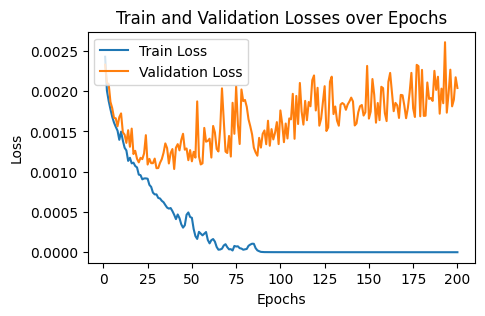

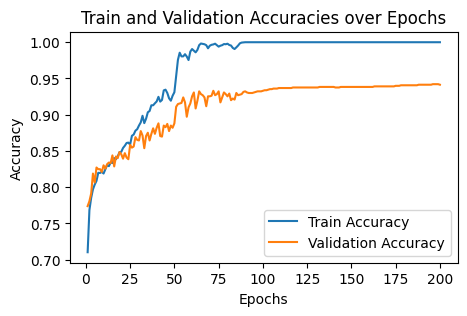

In [25]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [23]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/5000_GRU_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 6/6 [00:00<00:00, 490.34it/s]

Best epoch: 196
macro F1 Score: 0.9022830371086488
AUROC: 0.9581323545627826
Accuracy: 0.9231354642313546


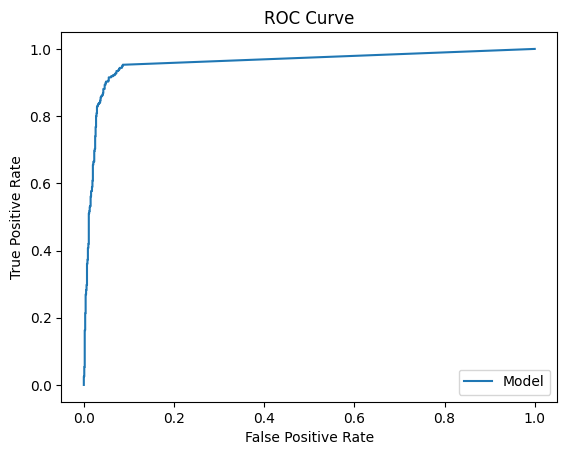

In [27]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)